# Clustering Neural Spike Data

## 1. Introduction:

Extracellular recordings can provide information about neuronal activity in the brain. A recorded signal by the microwire will be amplified and filtered to create waveforms that are a combination of background activity and nearby neuronal firing from a clusters of neurons in the form of spikes. This waveform is further processed (Ex. using amplitude thresholding) to identify the spikes. The next step is to group these spikes into clusters. The assumption is that neurons tend to fire spikes of a particular shape and by exploring diffrences and similarities in the spike shape, one can potentially separate spikes according to their particular population of neurons.

In this activity, we will process sample neuronal voltage recordings and use the Principal Component Analysis (PCA) to separate spikes.

Reference:

http://www.scholarpedia.org/article/Spike_sorting

## 2.1 Read the data:

You are provided with a matlab file **SpikeSorting.mat** that contains waveform volatage recording from population of neurons. Read this file using **scipy** module. This data has been preprocesed and centered for each spike to coincide with the others. Each spike contains 70 recorings representing 70 $ms$ of data. 

In [1]:
# read mat files containing the voltage data

import scipy.io
import numpy as np

# note: convert to pandas data frame or numpy
mat = scipy.io.loadmat('SpikeSorting.mat')


## 2.1 Extract and display the data:

The Matlab file contains two sets of arrays: 

1) spikes : indicies where each spike is detected in the voltage recording.

2) voltage: recording of neuronal firing as voltages. Use the indicies in the **spikes** array to extract recordings for each spike (recall that each spike has 70 recordings).

Use numpy to generate a two dimensional array in which rows are observed spikes and columns are voltage readings for each spike. Display all spikes in one figure.

(3298, 70)


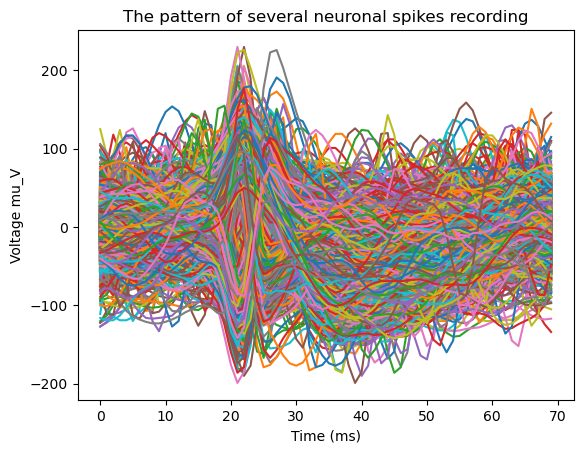

In [2]:
import matplotlib.pyplot as plt
# allow using latex in matplotlib
# plt.rcParams['text.usetex'] = True

# Data structure

# spikes array: contains indicies defining the initial location of each spike in the voltage array. 
# The total number of elements in the spikes array defines the total number of spikes in the recorded data

# voltage array: recorded voltage waveforms for different spikes. Each spike has 70 recordings. Use indicies in the 
# "spikes" array to generate a two dimensional array in which rows are observed spikes and columns 
# are voltage readings for each spike


spikes = np.squeeze(mat['spikes'])
voltages = np.squeeze(mat['voltage'])

obser_num = np.size(mat['spikes'])
num_samples = 70 # hard coded

data_array = np.zeros((obser_num,num_samples))

print(data_array.shape)

for n in range(obser_num):
    
    data_array[n,:] = voltages[spikes[n]: spikes[n] + 70]
    
    plt.plot(np.arange(70),data_array[n,:])

plt.xlabel(r'Time (ms)')
# plt.ylabel(r'Voltage $\displaystyle (\mu V)$')
plt.ylabel(r'Voltage mu_V')
plt.title('The pattern of several neuronal spikes recording')
plt.show()

### Part 1: Dimensionality Reduction with PCA

[7pts] Apply prinicpal component analysis to reduce the data from 70 raw features (time stamples) down to 2 principal components. Plot a scatterplot showing the first two principal components for the full dataset



(3298, 2)


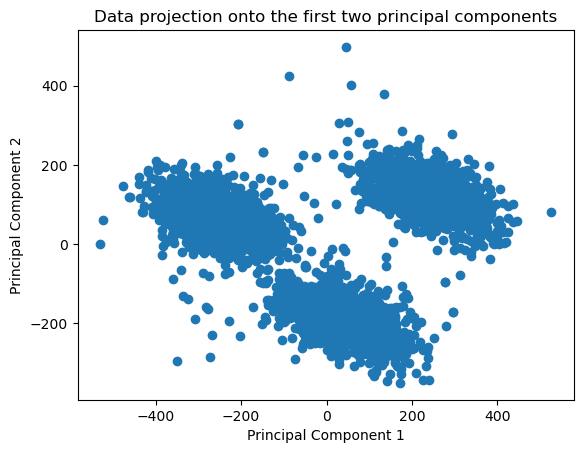

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca.fit(data_array)
components = pca.transform(data_array)
print(components.shape)

voltage_mean = np.mean(data_array, axis = 0)
data_mean_sub = data_array - voltage_mean
data_cov = (data_mean_sub.T@data_mean_sub)/(obser_num - 1)
eig, eVec = np.linalg.eigh(data_cov)
eig = eig[::-1]
eVec = eVec[:,::-1]
data_proj = data_mean_sub @ eVec[:,:]

plt.scatter(data_proj[:,0], data_proj[:,1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Data projection onto the first two principal components')
plt.show()

### Part 2: Clustering with Gaussian Mixture Models

[7pts] Apply gaussian mixture models with 3 clusters. Train the model on the full dataset.


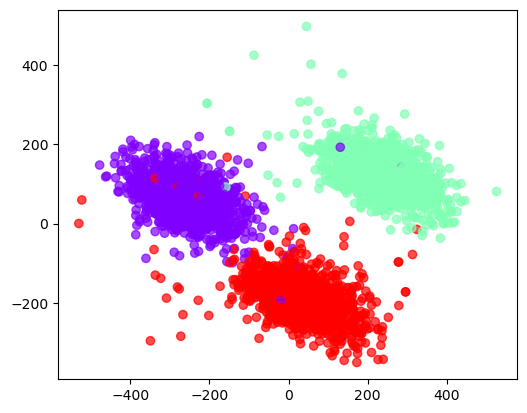

In [4]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3)
gmm.fit(data_array)
Cpred = gmm.predict(data_array)
ax = plt.subplot(111, aspect='equal')
plt.scatter(data_proj[:,0], data_proj[:,1], c=Cpred, cmap=plt.cm.rainbow, alpha=0.7)

### Part 3: Reconstruct Different Types of Spikes

[5pts] Use the trained gaussian mixture model to sample five new examples of the 2 prinicipal component coefficients from each of the three clusters. Then, use those sampled prinicipal component coefficients (eigen values) together with the corresponding principal components (eigen vectors) to create an approximation of the 70ms signal for each of the fifteen samples (3 clusters, 5 samples per cluster). Create three figures, one for each cluster, with the plots of the five 70ms signals. Add a title to indicate neural spike type A, neural spike type B and neural spike type C.

Text(0.5, 1.0, 'neural spike type C')

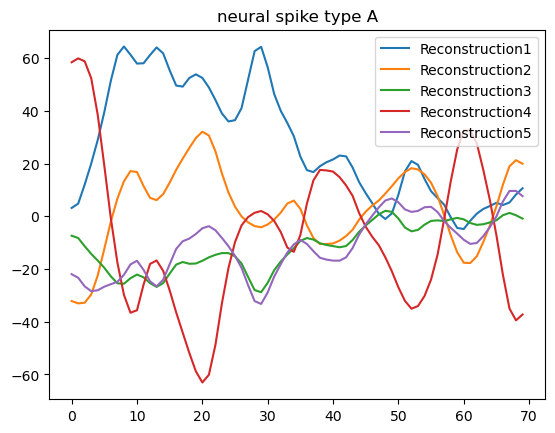

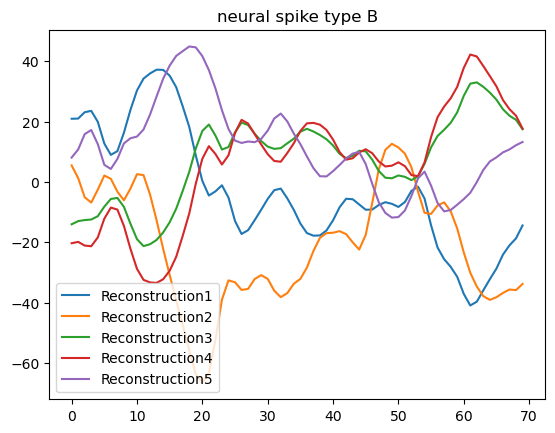

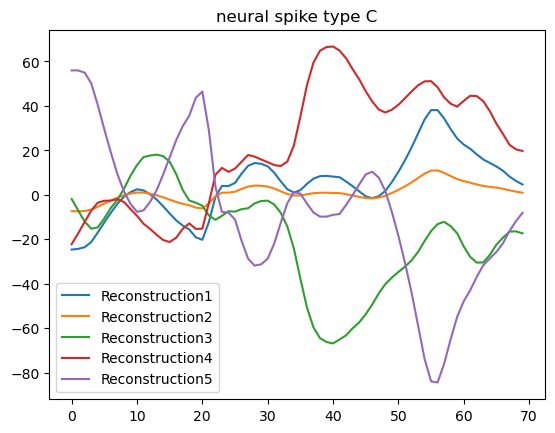

In [5]:
#reconstruct and plot
def recons(a):
    voltage_mean = np.mean(a, axis = 0)
    data_mean_sub = a - voltage_mean
    data_cov = (data_mean_sub.T@data_mean_sub)/(obser_num - 1)
    eig, eVec = np.linalg.eigh(data_cov)
    eig = eig[::-1]
    eVec = eVec[:,::-1]
    x = np.arange(70)
    t2 = eVec[:,:2]

    plt.figure()
    for n in range(5):
        spike = data_mean_sub[n,:]
        pc2 = spike @ t2
        spike01_reco = pc2@t2.T
        plt.plot(x,spike01_reco.T,label=f'Reconstruction{n+1}')

#plt.figure()
#plt.plot(x,spike01_reco.T,label=f'Reconstruction')
    plt.legend()

C_means= gmm.means_
C_cov = gmm.covariances_
#get random samples with 3 different clusters
a1 = np.random.multivariate_normal(C_means[0],C_cov[0],size = 5)
a2 = np.random.multivariate_normal(C_means[1],C_cov[1],size = 5)
a3 = np.random.multivariate_normal(C_means[2],C_cov[2],size = 5)
recons(a1)
plt.title('neural spike type A')
recons(a2)
plt.title('neural spike type B')
recons(a3)
plt.title('neural spike type C')

### Part 4: Provide an Interpretation of the Clusters

[5pts] Write an explanation about how to interpret these three types of neural signals. Why do you think this type of clustering analysis could be useful?

Answer: We can see that although the samples obtained by means and cov are randomly generated, the model can still fit a general trend. This is related to the principle of the Gaussian mixture model, which is an aggregation algorithm, assuming that the data of each cluster conforms to the Gaussian distribution, and the distribution presented by the current data is the result of the superposition of the Gaussian distributions of each cluster. The Gaussian mixture model is a statistical model that is a mixture of two or more Gaussian distributions. The model is used to represent the distribution of the dataset and can be used for classification and clustering tasks. Where this model is useful in its ability to handle datasets with missing values and perform well on datasets with non-linear boundaries and Gaussian mixture models are less sensitive to outliers than other types of models.